### EDA
### Data Cleaning

### Data Validation


Python Libraries

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots 
import plotly.graph_objects as go
from feature_engine.encoding import WoEEncoder, RareLabelEncoder
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTETomek
from sklearn.metrics import confusion_matrix # evaluation metric
from sklearn.metrics import accuracy_score # evaluation metric
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as PyPlot
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC # SVM algorithm
from sklearn.linear_model import LogisticRegression # Logistic regression algorithm






In [108]:
df= pd.read_csv("../DataSet/Churn_Modelling.csv")
df.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Data Validation 

In [109]:
#DATA VALIDATION 

def validate_data(df):
    issues = {}
    
    # Validate negative values in specific columns
    columns_to_check = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
    for column in columns_to_check:
        invalid_values = df[df[column] < 0]
        if not invalid_values.empty:
            issues[column] = invalid_values

    # Logical range checks
    if (df['Age'] > 120).any():
        issues['Age'] = df[df['Age'] > 120]
    if (df['CreditScore'] > 850).any():
        issues['CreditScore'] = df[df['CreditScore'] > 850]

    if issues:
        print("Data Validation Issues Detected:")
        for key, value in issues.items():
            print(f"{key}: {len(value)} invalid rows")
        return issues
    else:
        print("No validation issues detected.")
        return None

# Usage
issues = validate_data(df)


No validation issues detected.


#### Deleting Irrelevant Rows

In [110]:
df = df.drop("CustomerId", axis = 1)
df = df.drop("RowNumber", axis =1)



In [111]:
ColumnFeatures=df.columns.tolist()
print(ColumnFeatures)   


['Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


#### Replacing Negative Values In CreditScore Column

In [112]:
# Replace negative CreditScore values with NaN
df['CreditScore'] = df['CreditScore'].apply(lambda x: x if x >= 0 else np.nan)

# Alternatively, replace NaNs with the median (or mean) of the column
df['CreditScore'].fillna(df['CreditScore'].median(), inplace=True)


/tmp/ipykernel_6730/3004824043.py:5: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





#### Dataset Overview

In [113]:
def data_overview(df):
    print("### Dataset Overview ###")
    print("Shape of the dataset:", df.shape)
    print("\nData Types:\n", df.dtypes)
    print("\nMissing Values:\n", df.isnull().sum())
    print("\nFirst 5 Rows:\n", df.head())


In [114]:

data_overview(df)


### Dataset Overview ###
Shape of the dataset: (10000, 12)

Data Types:
 Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

Missing Values:
 Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

First 5 Rows:
     Surname  CreditScore Geography  Gender  Age  Tenure    Balance  \
0  Hargrave          619    France  Female   42       2       0.00   
1      Hill          608     Spain  Female   41       1   83807.86   
2      Onio          502    France  Female   42       8  159660.80   
3      Bon

In [115]:
def five_number_summary(df):
    print("\n### Five-Number Summary ###")
    num_columns = df.select_dtypes(include=[np.number]).columns
    summary = df[num_columns].describe(percentiles=[0.25, 0.5, 0.75]).loc[['min', '25%', '50%', '75%', 'max']]
    print(summary)
    return summary


In [116]:

five_number_summary(df)



### Five-Number Summary ###
     CreditScore   Age  Tenure    Balance  NumOfProducts  HasCrCard  \
min        350.0  18.0     0.0       0.00            1.0        0.0   
25%        584.0  32.0     3.0       0.00            1.0        0.0   
50%        652.0  37.0     5.0   97198.54            1.0        1.0   
75%        718.0  44.0     7.0  127644.24            2.0        1.0   
max        850.0  92.0    10.0  250898.09            4.0        1.0   

     IsActiveMember  EstimatedSalary  Exited  
min             0.0          11.5800     0.0  
25%             0.0       51002.1100     0.0  
50%             1.0      100193.9150     0.0  
75%             1.0      149388.2475     0.0  
max             1.0      199992.4800     1.0  


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
min,350.0,18.0,0.0,0.00,1.0,0.0,0.0,11.5800,0.0
25%,584.0,32.0,3.0,0.00,1.0,0.0,0.0,51002.1100,0.0
50%,652.0,37.0,5.0,97198.54,1.0,1.0,1.0,100193.9150,0.0
75%,718.0,44.0,7.0,127644.24,2.0,1.0,1.0,149388.2475,0.0
max,850.0,92.0,10.0,250898.09,4.0,1.0,1.0,199992.4800,1.0


In [117]:

def plot_numeric_distributions(df, cols_per_row=3, bins=10):
    """
    Plot frequency distributions for numeric columns in a DataFrame.

    Parameters:
        df (DataFrame): The input DataFrame.
        cols_per_row (int): Number of plots per row (default is 3).
        bins (int): Number of bins for the histograms (default is 10).

    Returns:
        None
    """
    # Select numeric columns
    numeric_cols = df.select_dtypes(include='number')
    num_cols = len(numeric_cols.columns)
    num_rows = (num_cols + cols_per_row - 1) // cols_per_row  # Calculate number of rows needed

    # Create subplots
    fig, axarr = plt.subplots(num_rows, cols_per_row, figsize=(15, num_rows * 3), sharey=True)
    axarr = axarr.flatten()  # Flatten the axes for easy indexing

    for ind, col in enumerate(numeric_cols.columns):
        axarr[ind].hist(df[col], bins=bins, color='blue', alpha=0.7, edgecolor='black')
        axarr[ind].set_title(f'Distribution of {col}', fontsize=12)
        axarr[ind].set_xlabel(col)
        axarr[ind].set_ylabel('Frequency')

    # Turn off unused subplots
    for i in range(ind + 1, len(axarr)):
        axarr[i].axis('off')

    plt.tight_layout()
    plt.suptitle("Frequency Distribution of Numeric Columns", fontsize=16, y=1.05)
    plt.show()


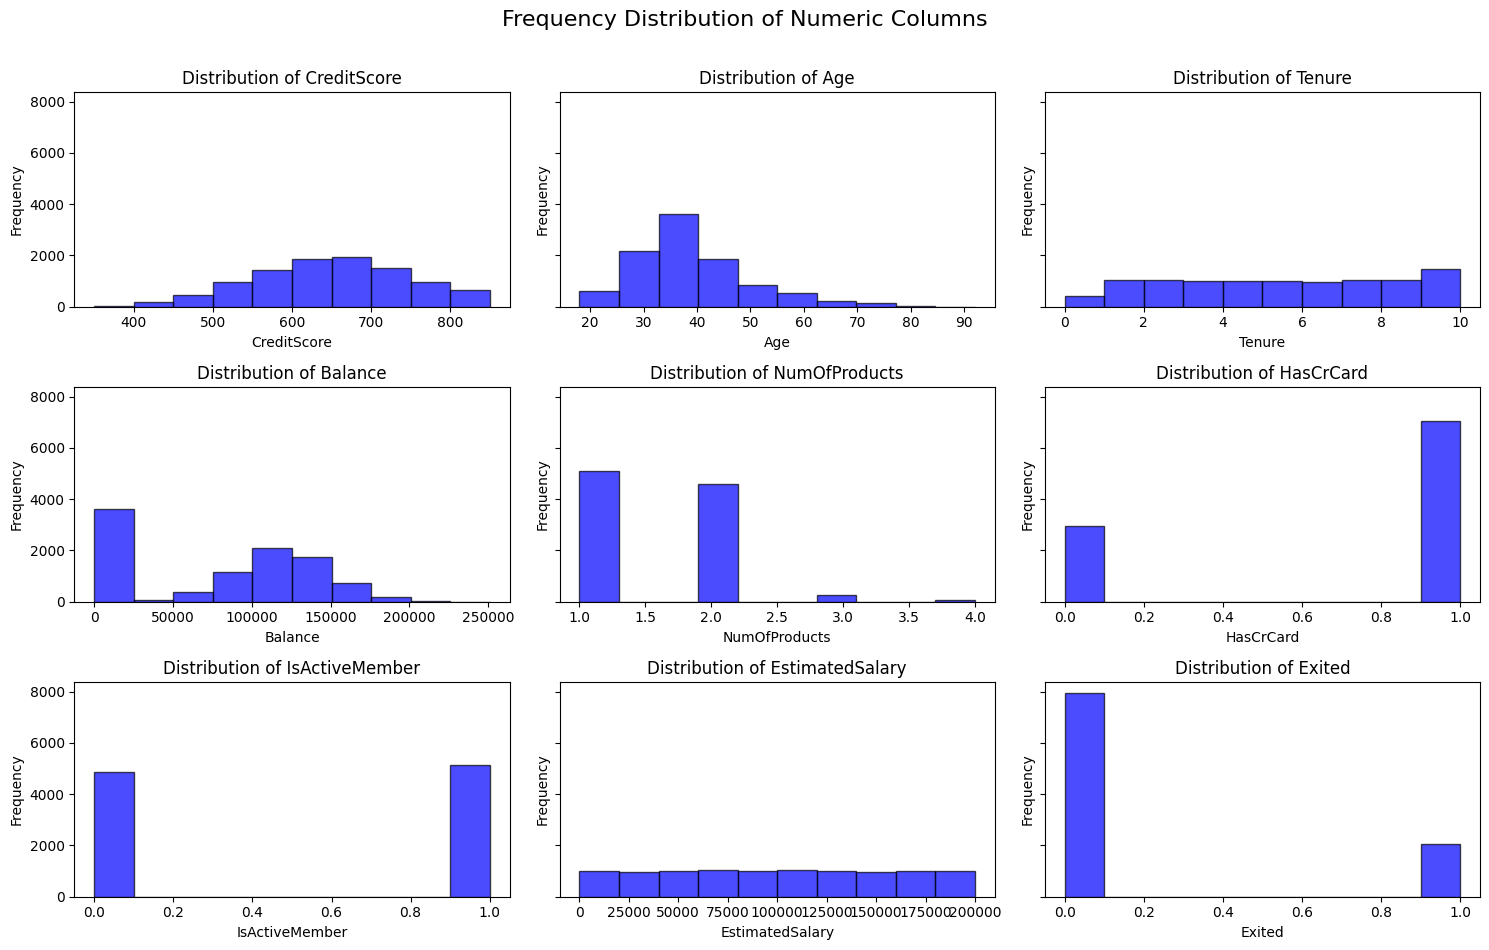

In [118]:

plot_numeric_distributions(df, cols_per_row=3, bins=10)



In [119]:
def categorical_univariate_analysis(df):
   
    print("\n### Categorical Univariate Analysis ###")
    cat_columns = df.select_dtypes(include=['object', 'category']).columns
    num_plots = len(cat_columns)
    
    rows = (num_plots // 3) + (num_plots % 3 > 0)
    
    fig, axes = plt.subplots(rows, 3, figsize=(18, rows * 5))
    axes = axes.flatten()
    
    for i, col in enumerate(cat_columns):
        sns.countplot(y=df[col], palette=['#5e3023', '#c08552', '#f3e9dc'], ax=axes[i])  # Custom hex colors
        axes[i].set_title(f'Count of {col}')
        axes[i].set_xlabel('Count')
        axes[i].set_ylabel(col)
    
    # Turn off empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()



### Categorical Univariate Analysis ###


/tmp/ipykernel_6730/1425442141.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_6730/1425442141.py:13: UserWarning:


The palette list has fewer values (3) than needed (2932) and will cycle, which may produce an uninterpretable plot.

/tmp/ipykernel_6730/1425442141.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_6730/1425442141.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_6730/1425442141.py:13: UserWarning:

The palette list has more values (3) than needed (2), which may not be intended.



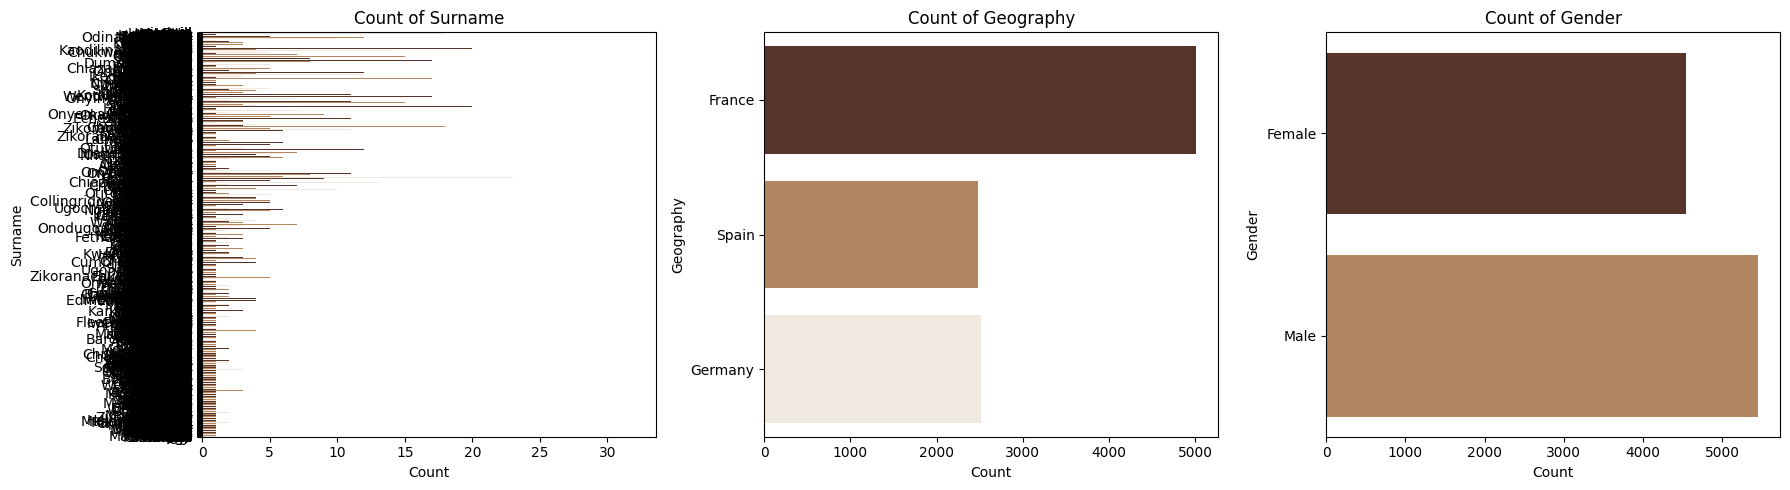

In [120]:

categorical_univariate_analysis(df)


In [121]:
def pairplot_bivariate_analysis(df, target_column):
    print("\n### Pairplot Bivariate Analysis ###")
    
    # Use the custom color for the pairplot
    custom_color = '#758ecd'  # Updated color
    
    # Pair plot for numerical variables
    sns.pairplot(df, hue=target_column, diag_kind='kde')
    plt.suptitle("Pairplot of Numerical Features", y=1.02)
    plt.show()


In [122]:
#pairplot_bivariate_analysis(df, target_column='Exited')


In [123]:
def correlation_heatmap_bivariate_analysis(df):
    print("\n### Correlation Heatmap Bivariate Analysis ###")
    num_columns = df.select_dtypes(include=[np.number]).columns

    # Create the heatmap using the custom color palette
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[num_columns].corr(), annot=True, cmap=['#5dd9c1', '#acfcd9', '#b084cc', '#665687', '#190933'], fmt='.2f')
    plt.title("Correlation Matrix")
    plt.show()



### Correlation Heatmap Bivariate Analysis ###


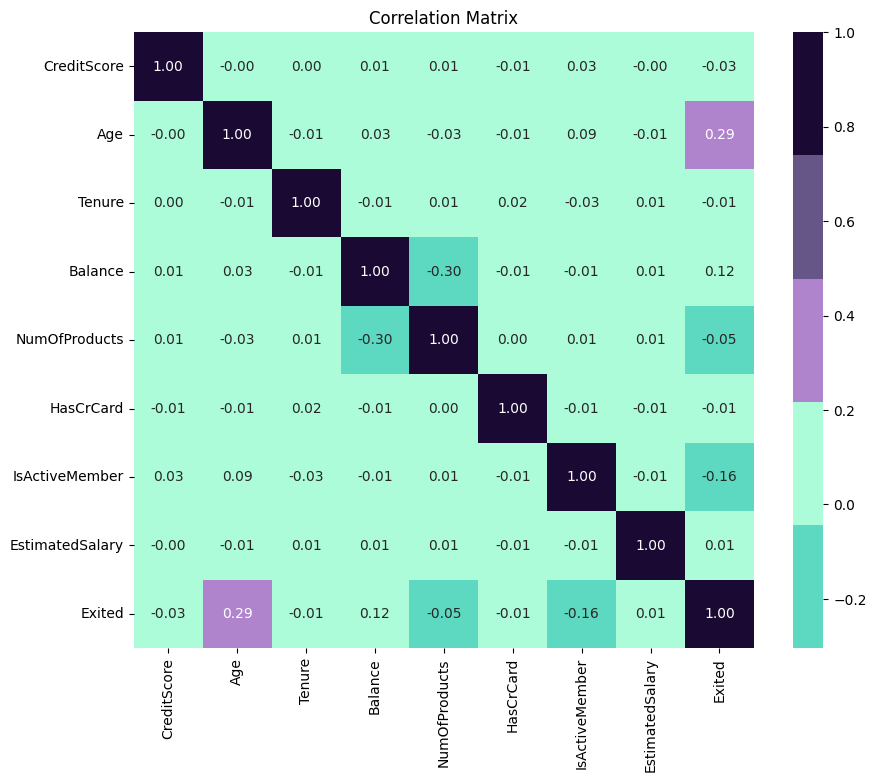

In [124]:

correlation_heatmap_bivariate_analysis(df)


In [125]:
def detect_outliers(df):
    print("\n### Outlier Detection ###")
    num_columns = df.select_dtypes(include=[np.number]).columns
    outliers_summary = {}
    for col in num_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_summary[col] = len(outliers)
        print(f"{col}: {len(outliers)} outliers detected")
    #return outliers_summary


In [126]:

detect_outliers(df)



### Outlier Detection ###
CreditScore: 15 outliers detected
Age: 359 outliers detected
Tenure: 0 outliers detected
Balance: 0 outliers detected
NumOfProducts: 60 outliers detected
HasCrCard: 0 outliers detected
IsActiveMember: 0 outliers detected
EstimatedSalary: 0 outliers detected
Exited: 2037 outliers detected


In [127]:
def box_plot_outlier_detection(df):
    
    print("\n### Box Plot for Outlier Detection ###")
    num_columns = df.select_dtypes(include=[np.number]).columns
    num_plots = len(num_columns)
    
    rows = (num_plots // 3) + (num_plots % 3 > 0)
    
    fig, axes = plt.subplots(rows, 3, figsize=(18, rows * 5))
    axes = axes.flatten()
    
    for i, col in enumerate(num_columns):
        sns.boxplot(x=df[col], color='#758ecd', ax=axes[i])  # Custom color for the box plot
        axes[i].set_title(f'Box Plot of {col}')
        axes[i].set_xlabel(col)
    
    # Turn off empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()



### Box Plot for Outlier Detection ###


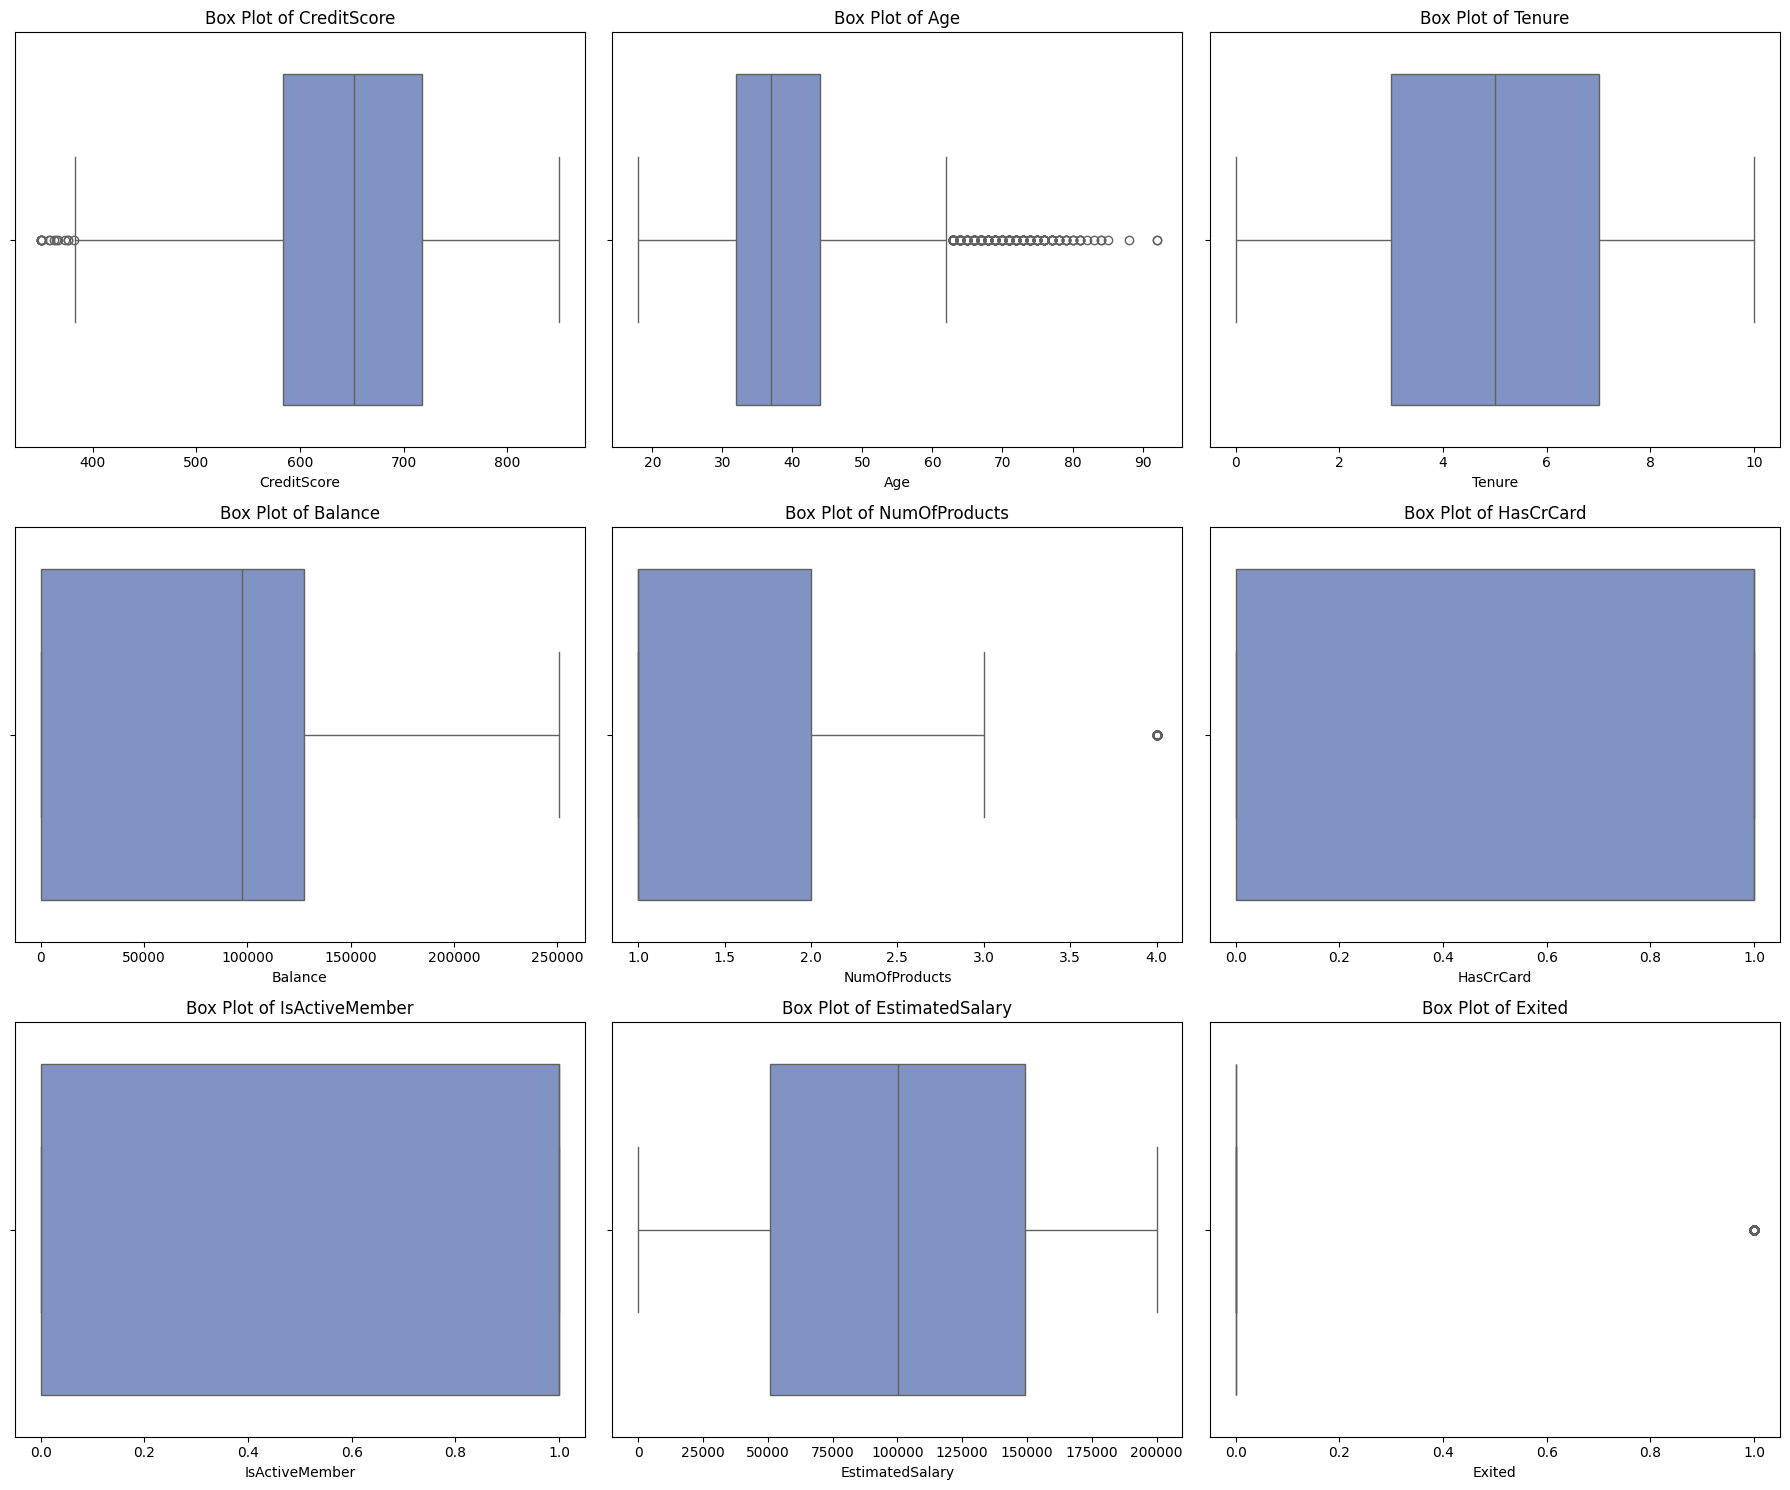

In [128]:

box_plot_outlier_detection(df)


In [129]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plot_numeric_boxplots(df, cols_per_row=3):
    """
    Create box plots for numeric columns in a DataFrame, arranged in multiple rows.

    Parameters:
        df (DataFrame): The input DataFrame.
        cols_per_row (int): Number of plots per row.

    Returns:
        None
    """
    # Select numeric columns
    numeric_cols = df.select_dtypes(include='number')
    num_cols = len(numeric_cols.columns)
    rows = (num_cols // cols_per_row) + (num_cols % cols_per_row > 0)

    # Create subplots
    fig = make_subplots(
        rows=rows, cols=cols_per_row,
        subplot_titles=numeric_cols.columns
    )

    # Add box plot traces
    for i, col in enumerate(numeric_cols.columns):
        row = (i // cols_per_row) + 1
        col_position = (i % cols_per_row) + 1
        fig.add_trace(
            go.Box(y=numeric_cols[col], name=col, boxmean=True),
            row=row, col=col_position
        )

    # Update layout
    fig.update_layout(
        height=rows * 400,  # Adjust height dynamically based on the number of rows
        width=cols_per_row * 200,
        title_text="Box Plots for Numeric Columns",
        showlegend=False,
        template="plotly_dark"
    )

    # Show the figure
    fig.show()


In [130]:
plot_numeric_boxplots(df, cols_per_row=6)


#### Cleanesed Data Export To CSV File

In [131]:

# Save the cleaned dataset as a CSV file
file_path = "../DataSet/cleaned_customer_churn_data.csv"
df.to_csv(file_path, index=False)

# Check the current working directory
current_directory = os.getcwd()
print("Current working directory:", current_directory)

# Check if the file exists in the directory
if os.path.exists(file_path):
    print(f"File has been saved successfully at {file_path}")
else:
    print(f"File not found at {file_path}")


Current working directory: /mnt/sda1/OneDrive/Codes/CDAC_Project_Work/Implementation
File has been saved successfully at ../DataSet/cleaned_customer_churn_data.csv


In [132]:
def encode_categorical(df):
    print("\n### Encoding Categorical Variables ###")
    cat_columns = df.select_dtypes(include=['object', 'category']).columns
    df_encoded = pd.get_dummies(df, columns=cat_columns, drop_first=True)
    print(f"Categorical columns encoded: {list(cat_columns)}")
    return df_encoded


In [133]:

df_encoded = encode_categorical(df)



### Encoding Categorical Variables ###
Categorical columns encoded: ['Surname', 'Geography', 'Gender']


In [134]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def encoded_feature_vs_target_analysis(df, target_column, cols_per_row=2):
    """
    Create count plots for encoded categorical features against the target column, arranged in multiple rows.

    Parameters:
        df (DataFrame): The input DataFrame.
        target_column (str): The target column for the analysis.
        cols_per_row (int): Number of plots per row (default is 2).

    Returns:
        None
    """
    # Encoded categorical features
    encoded_categorical_columns = ['Geography', 'Gender']
    num_plots = len(encoded_categorical_columns)
    rows = (num_plots // cols_per_row) + (num_plots % cols_per_row > 0)

    # Create subplots
    fig = make_subplots(
        rows=rows, cols=cols_per_row,
        subplot_titles=encoded_categorical_columns
    )

    # Add count plot traces
    for i, col in enumerate(encoded_categorical_columns):
        row = (i // cols_per_row) + 1
        col_position = (i % cols_per_row) + 1
        fig.add_trace(
            go.Bar(
                x=df[col],
                y=df.groupby(col)[target_column].value_counts().values,
                name=f'{col} vs {target_column}',
                marker=dict(color=['#6e5082', '#3a2b51', '#b084cc']),
            ),
            row=row, col=col_position
        )

    # Update layout
    fig.update_layout(
        height=rows * 400,  # Adjust height dynamically based on the number of rows
        width=cols_per_row * 400,
        title_text="Encoded Feature vs Target Column Analysis",
        showlegend=False,
        template="plotly_dark"
    )

    # Show the figure
    fig.show()


In [135]:

# Define the target column
target_column = 'Exited'

# Call the function with the target column
encoded_feature_vs_target_analysis(df, target_column)


In [136]:
df


,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [137]:
def feature_engineering(df):
    print("\n### Feature Engineering ###")

    # 1. Example of creating an interaction feature (Age * Tenure)
    df['Age_Tenure'] = df['Age'] * df['Tenure']
    
    # 2. Creating a squared feature for Age to capture any non-linear relationship
    df['Age_Squared'] = df['Age'] ** 2

    # 3. Normalizing numerical columns (CreditScore, Balance, EstimatedSalary)
    
    scaler = StandardScaler()
    df[['CreditScore', 'Balance', 'EstimatedSalary']] = scaler.fit_transform(df[['CreditScore', 'Balance', 'EstimatedSalary']])

    # 4. Dropping the 'Surname' column as it is unlikely to be useful
    df.drop(columns=['Surname'], inplace=True)

    print("New feature columns added:", ['Age_Tenure', 'Age_Squared'])


In [138]:
#feature_engineering(df)


In [139]:
X = df.copy()[ColumnFeatures]
Y = X.pop('Exited')


### Counting number of records in our dataset By Customer Churn And Churn

In [140]:
Y.value_counts()


Exited
0    7963
1    2037
Name: count, dtype: int64

#### # Data Encoding Functions And Libraries for Encoding The Data 

In [141]:
RareEncoder = RareLabelEncoder(tol=0.005, n_categories=1, variables=['Geography', 'Gender','Surname'])
EncodedData = RareEncoder.fit_transform(X)
woe_encoder = WoEEncoder(variables=['Geography', 'Gender','Surname'])
woe_encoder.fit(EncodedData , Y)
def TransFormData(X):
    EncodedData = RareEncoder.transform(X)
    return woe_encoder.transform(EncodedData)


### # Example Of How Data Is Gonna Be Encoded

In [142]:
woe_encoder.encoder_dict_


{'Geography': {'France': -0.2834298082997183,
  'Germany': 0.6298500222186288,
  'Spain': -0.2456258576097814},
 'Gender': {'Female': 0.26852714978455633, 'Male': -0.2613608358806028},
 'Surname': {'Rare': 0.0}}

### # Passing Our Train Data To Make It Encoded

In [143]:
TransFormData(X)


,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,0.0,619,-0.283430,0.268527,42,2,0.00,1,1,1,101348.88
1,0.0,608,-0.245626,0.268527,41,1,83807.86,1,0,1,112542.58
2,0.0,502,-0.283430,0.268527,42,8,159660.80,3,1,0,113931.57
3,0.0,699,-0.283430,0.268527,39,1,0.00,2,0,0,93826.63
4,0.0,850,-0.245626,0.268527,43,2,125510.82,1,1,1,79084.10
...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,771,-0.283430,-0.261361,39,5,0.00,2,1,0,96270.64
9996,0.0,516,-0.283430,-0.261361,35,10,57369.61,1,1,1,101699.77
9997,0.0,709,-0.283430,0.268527,36,7,0.00,1,0,1,42085.58
9998,0.0,772,0.629850,-0.261361,42,3,75075.31,2,1,0,92888.52


#### #Spliting Data Into Test-Train SubSet

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


#### # Balancing Train And Test Data To Reduce Training And Testing Of Models By A Great Extent


In [145]:
RandomSampler = RandomUnderSampler(random_state=42)
TrainDataSetUnderSampling, Y_Train_DataUnderSampling = RandomSampler.fit_resample(TransFormData(X_train), y_train)
TestDataFinalUnderSampling, Y_Test_DataUnderSampling = RandomSampler.fit_resample(TransFormData(X_test), y_test)


#### # SMOTE: - Oversampling

In [146]:
oversampler= SMOTE(random_state=42)
TrainDataSetSmote, Y_Train_DataSmote = oversampler.fit_resample(TransFormData(X_train), y_train)
TestDataFinalSmote, Y_Test_DataSmote = oversampler.fit_resample(TransFormData(X_test), y_test)


#### # SMOTE TOMEK OverSampling Of Data

In [147]:
SmoteTomek = SMOTETomek()
TrainDataSetSmoteTomek, Y_Train_DataSmoteTomek = SmoteTomek.fit_resample(TransFormData(X_train), y_train)
TestDataFinalTomek, Y_Test_DataSmoteTomek = SmoteTomek.fit_resample(TransFormData(X_test), y_test)


#### # Function To Plot The Model Evaluations

In [148]:
def PlotConfusionMatrix(y_test, y_pred):
    display_labels = ['Exited', 'Not Exited']
    ConfusionMatrix = confusion_matrix(y_test, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=ConfusionMatrix,display_labels=display_labels)
    disp = disp.plot(cmap='BuGn', xticks_rotation=30)
    PyPlot.show()


#### # Variables For Storing Results

In [149]:
ClassificationReport=[]
AccuracyScoreList=[]
PrecisionScoreList=[]
F1ScoreList=[]
RecallScoreList=[]
SenstivityList=[]
SpecificityList=[]


#### Implementation Of RandomForest

In [150]:
def RandomForestFunction(TrainDataSet,Y_Train_Data,TestDataFinal,Y_Test_Data):
    parameters = {'max_depth': [3, 5, 10],'min_samples_split': [2, 5, 10]}
    RandomForestModel = RandomForestClassifier()
    Classifier = GridSearchCV(RandomForestModel, parameters,scoring='accuracy',cv=5)
    Classifier.fit(TrainDataSet, Y_Train_Data)
    ModelPrediction = Classifier.predict(TestDataFinal)
    print('Classification Report of Random Forest Tree Algorithm')
    print(classification_report(Y_Test_Data, ModelPrediction))
    ClassificationReport.append(classification_report(Y_Test_Data, ModelPrediction))
    print('\n\nAccuracy score of the Random Forest Tree model is = ',accuracy_score(Y_Test_Data, ModelPrediction))
    AccuracyScoreList.append(accuracy_score(Y_Test_Data, ModelPrediction))
    PrecisionScoreList.append(precision_score(Y_Test_Data, ModelPrediction))
    F1ScoreList.append(f1_score(Y_Test_Data, ModelPrediction))
    print('\n\nConfusion Matrix Of Random Forest Tree Model')
    PlotConfusionMatrix(Y_Test_Data,ModelPrediction)
    RecallScoreList.append(recall_score(Y_Test_Data, ModelPrediction, average='macro'))
    ConfusionMatrix = confusion_matrix(Y_Test_Data,ModelPrediction, normalize='true')
    Sensitivity = ConfusionMatrix[0,0]/(ConfusionMatrix[0,0]+ConfusionMatrix[0,1])
    print('Sensitivity Of This Model Is : ', Sensitivity )
    Specificity = ConfusionMatrix[1,1]/(ConfusionMatrix[1,0]+ConfusionMatrix[1,1])
    print('Specificity Of This Model Is : : ', Specificity)
   
    SenstivityList.append(Sensitivity)
    SpecificityList.append(Specificity)
    
    #ROC Curve 
    ModelPrediction_Probability = Classifier.predict_proba(TestDataFinal)[::,1]
    fpr, tpr, _ = metrics.roc_curve(Y_Test_Data,  ModelPrediction_Probability)
    roc_auc = metrics.auc(fpr, tpr)
    PyPlot.figure()
    lw = 2
    PyPlot.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    PyPlot.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    PyPlot.xlabel("False Positive Rate")
    PyPlot.ylabel("True Positive Rate")
    PyPlot.title("ROC Curve")
    PyPlot.legend(loc="lower right")
    PyPlot.show()



Classification Report of Random Forest Tree Algorithm
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       584
           1       0.79      0.76      0.77       584

    accuracy                           0.78      1168
   macro avg       0.78      0.78      0.78      1168
weighted avg       0.78      0.78      0.78      1168



Accuracy score of the Random Forest Tree model is =  0.7773972602739726


Confusion Matrix Of Random Forest Tree Model


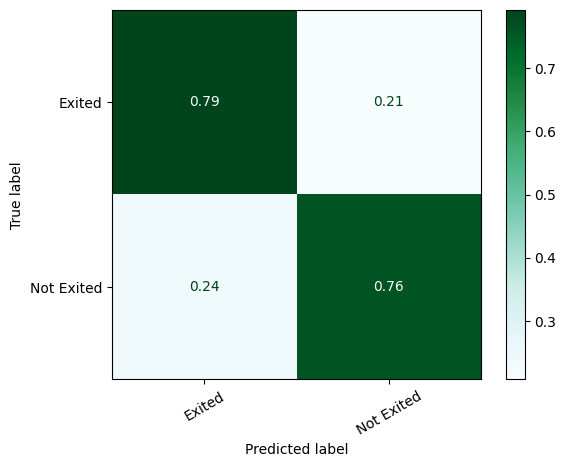

Sensitivity Of This Model Is :  0.7928082191780822
Specificity Of This Model Is : :  0.761986301369863


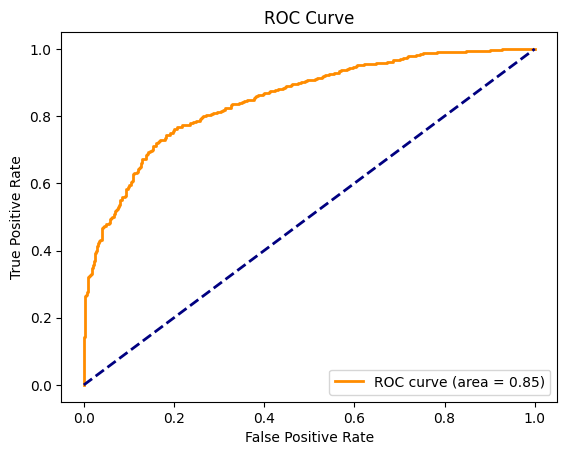

In [151]:
RandomForestFunction(TrainDataSetUnderSampling,Y_Train_DataUnderSampling,TestDataFinalUnderSampling,Y_Test_DataUnderSampling)


Classification Report of Random Forest Tree Algorithm
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      2416
           1       0.90      0.83      0.86      2416

    accuracy                           0.87      4832
   macro avg       0.87      0.87      0.87      4832
weighted avg       0.87      0.87      0.87      4832



Accuracy score of the Random Forest Tree model is =  0.8669288079470199


Confusion Matrix Of Random Forest Tree Model


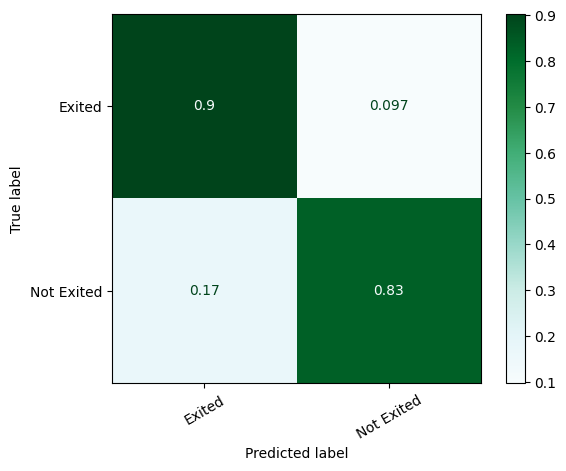

Sensitivity Of This Model Is :  0.9031456953642384
Specificity Of This Model Is : :  0.8307119205298014


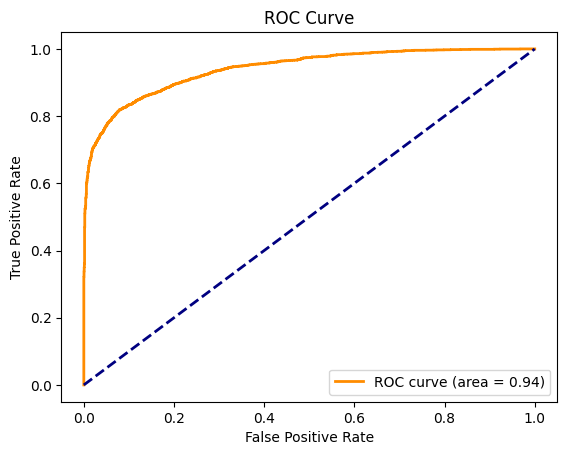

In [152]:
RandomForestFunction(TrainDataSetSmote,Y_Train_DataSmote,TestDataFinalSmote,Y_Test_DataSmote)


Classification Report of Random Forest Tree Algorithm
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      2028
           1       0.90      0.83      0.86      2028

    accuracy                           0.87      4056
   macro avg       0.87      0.87      0.87      4056
weighted avg       0.87      0.87      0.87      4056



Accuracy score of the Random Forest Tree model is =  0.8678500986193294


Confusion Matrix Of Random Forest Tree Model


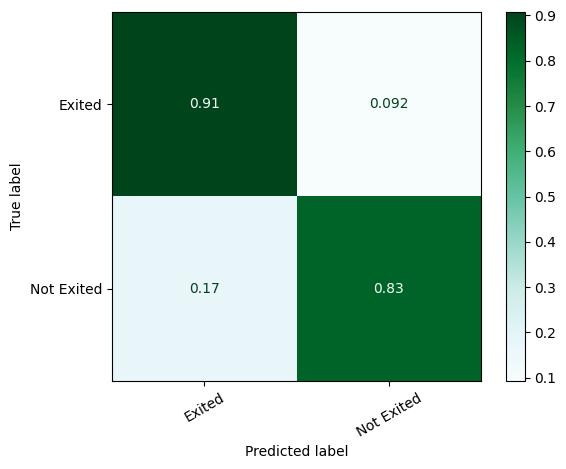

Sensitivity Of This Model Is :  0.908284023668639
Specificity Of This Model Is : :  0.8274161735700197


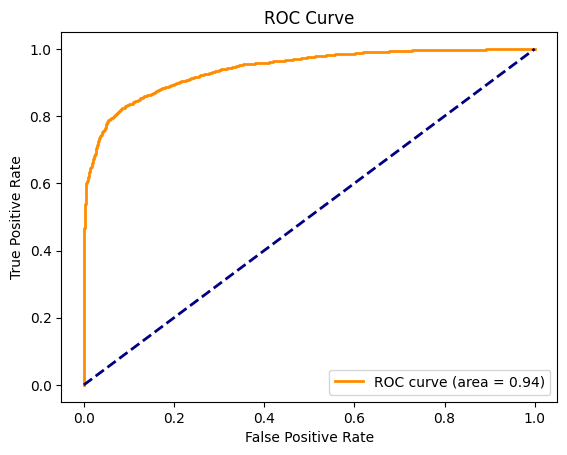

In [153]:
RandomForestFunction(TrainDataSetSmoteTomek,Y_Train_DataSmoteTomek,TestDataFinalTomek,Y_Test_DataSmoteTomek)


In [154]:
def SampleVectorModelFunction(TrainDataSet,Y_Train_Data,TestDataFinal,Y_Test_Data):
    SampleVectorMachineModel = SVC(probability=True)
    SampleVectorMachineModel.fit(TrainDataSet, Y_Train_Data)
    SampleVectorMachineModelPrediction = SampleVectorMachineModel.predict(TestDataFinal)
    print('Classification Report of Sample Vector Machine Algorithm')
    print(classification_report(Y_Test_Data, SampleVectorMachineModelPrediction))
    ClassificationReport.append(classification_report(Y_Test_Data, SampleVectorMachineModelPrediction))
    print('\n\nAccuracy score of the Sample Vector Machine model is = ',accuracy_score(Y_Test_Data, SampleVectorMachineModelPrediction))
    AccuracyScoreList.append(accuracy_score(Y_Test_Data, SampleVectorMachineModelPrediction))
    PrecisionScoreList.append(precision_score(Y_Test_Data, SampleVectorMachineModelPrediction))
    F1ScoreList.append(f1_score(Y_Test_Data, SampleVectorMachineModelPrediction))
    print('\n\nConfusion Matrix Of Sample Vector Machine Model')
    PlotConfusionMatrix(Y_Test_Data,SampleVectorMachineModelPrediction)
    
    RecallScoreList.append(recall_score(Y_Test_Data,SampleVectorMachineModelPrediction, average='macro'))
    ConfusionMatrix = confusion_matrix(Y_Test_Data,SampleVectorMachineModelPrediction, normalize='true')
    Sensitivity = ConfusionMatrix[0,0]/(ConfusionMatrix[0,0]+ConfusionMatrix[0,1])
    print('Sensitivity Of This Model Is : ', Sensitivity )
    Specificity = ConfusionMatrix[1,1]/(ConfusionMatrix[1,0]+ConfusionMatrix[1,1])
    print('Specificity Of This Model Is : : ', Specificity)
   
    SenstivityList.append(Sensitivity)
    SpecificityList.append(Specificity)
    

    #ROC Curve 
    ModelPredictioNumPyrobability = SampleVectorMachineModel.predict_proba(TestDataFinal)[::,1]
    fpr, tpr, _ = metrics.roc_curve(Y_Test_Data,  ModelPredictioNumPyrobability)
    roc_auc = metrics.auc(fpr, tpr)
    PyPlot.figure()
    lw = 2
    PyPlot.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    PyPlot.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    PyPlot.xlabel("False Positive Rate")
    PyPlot.ylabel("True Positive Rate")
    PyPlot.title("Receiver operating characteristic Curve")
    PyPlot.legend(loc="lower right")
    PyPlot.show()


Classification Report of Sample Vector Machine Algorithm
              precision    recall  f1-score   support

           0       0.59      0.37      0.45       584
           1       0.54      0.74      0.63       584

    accuracy                           0.56      1168
   macro avg       0.57      0.56      0.54      1168
weighted avg       0.57      0.56      0.54      1168



Accuracy score of the Sample Vector Machine model is =  0.5565068493150684


Confusion Matrix Of Sample Vector Machine Model


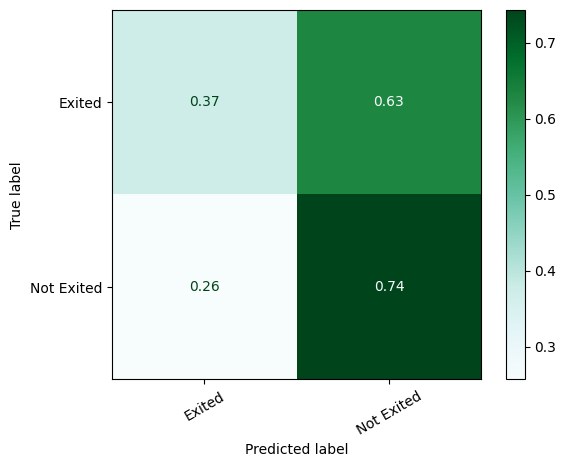

Sensitivity Of This Model Is :  0.3698630136986301
Specificity Of This Model Is : :  0.7431506849315068


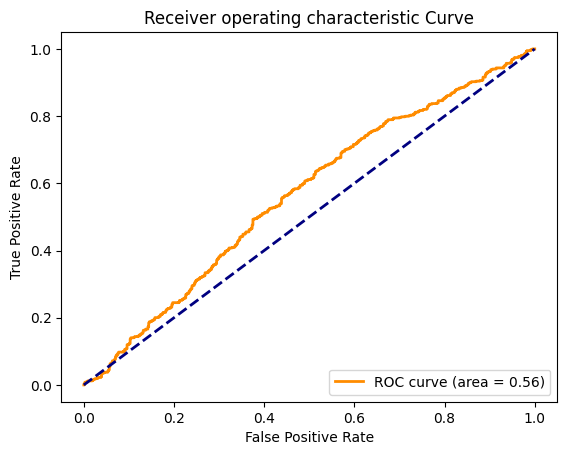

In [155]:
SampleVectorModelFunction(TrainDataSetUnderSampling,Y_Train_DataUnderSampling,TestDataFinalUnderSampling,Y_Test_DataUnderSampling)


In [156]:
def LogisticRegressionModelFunction(TrainDataSet,Y_Train_Data,TestDataFinal,Y_Test_Data):
    LogisticRegressionModel = LogisticRegression(solver='lbfgs', max_iter=10000)
    LogisticRegressionModel.fit(TrainDataSet, Y_Train_Data)
    LogisticRegressionModelPrediction = LogisticRegressionModel.predict(TestDataFinal)
    print('Classifaction Report Of Logistic Regression ')
    print(classification_report(Y_Test_Data, LogisticRegressionModelPrediction))
    ClassificationReport.append(classification_report(Y_Test_Data, LogisticRegressionModelPrediction))
    print('\n\nAccuracy score of the Logistic Regression model is = ',accuracy_score(Y_Test_Data, LogisticRegressionModelPrediction))
    AccuracyScoreList.append(accuracy_score(Y_Test_Data, LogisticRegressionModelPrediction))    
    PrecisionScoreList.append(precision_score(Y_Test_Data, LogisticRegressionModelPrediction))
    F1ScoreList.append(f1_score(Y_Test_Data, LogisticRegressionModelPrediction))
    print('\n\nConfusion Matrix Of Logistic Regression Model')
    PlotConfusionMatrix(Y_Test_Data,LogisticRegressionModelPrediction)
    RecallScoreList.append(recall_score(Y_Test_Data, LogisticRegressionModelPrediction, average='macro'))

    ConfusionMatrix = confusion_matrix(Y_Test_Data,LogisticRegressionModelPrediction, normalize='true')
    Sensitivity = ConfusionMatrix[0,0]/(ConfusionMatrix[0,0]+ConfusionMatrix[0,1])
    print('Sensitivity Of This Model Is : ', Sensitivity )
    Specificity = ConfusionMatrix[1,1]/(ConfusionMatrix[1,0]+ConfusionMatrix[1,1])
    print('Specificity Of This Model Is : : ', Specificity)
   
    SenstivityList.append(Sensitivity)
    SpecificityList.append(Specificity)
    
    
    
    #ROC Curve
    ModelPrediction_Probability = LogisticRegressionModel.predict_proba(TestDataFinal)[::,1]
    fpr, tpr, _ = metrics.roc_curve(Y_Test_Data,  ModelPrediction_Probability)
    roc_auc = metrics.auc(fpr, tpr)
    PyPlot.figure()
    lw = 2
    PyPlot.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    PyPlot.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    PyPlot.xlabel("False Positive Rate")
    PyPlot.ylabel("True Positive Rate")
    PyPlot.title("Receiver operating characteristic Curve")
    PyPlot.legend(loc="lower right")
    PyPlot.show()


Classifaction Report Of Logistic Regression 
              precision    recall  f1-score   support

           0       0.70      0.68      0.69       584
           1       0.69      0.71      0.70       584

    accuracy                           0.69      1168
   macro avg       0.69      0.69      0.69      1168
weighted avg       0.69      0.69      0.69      1168



Accuracy score of the Logistic Regression model is =  0.6943493150684932


Confusion Matrix Of Logistic Regression Model


/home/mr-arthor/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



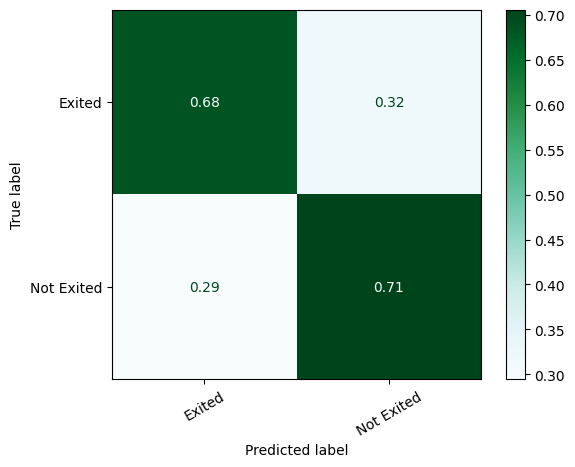

Sensitivity Of This Model Is :  0.6832191780821918
Specificity Of This Model Is : :  0.7054794520547946


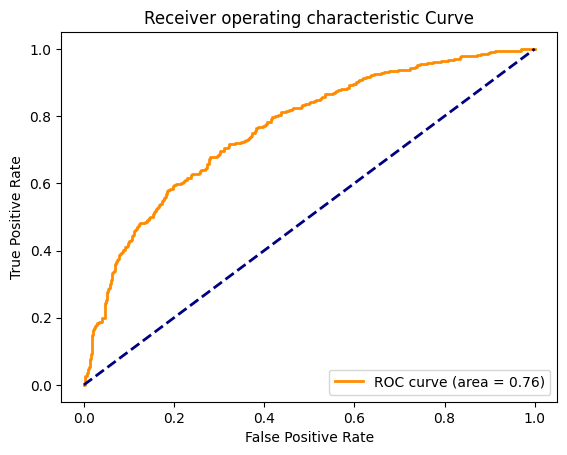

In [159]:
LogisticRegressionModelFunction(TrainDataSetUnderSampling,Y_Train_DataUnderSampling,TestDataFinalUnderSampling,Y_Test_DataUnderSampling)


In [162]:
from sklearn.neural_network import MLPClassifier

def NeuralNetworks(TrainDataSet,Y_Train_Data,TestDataFinal,Y_Test_Data, Epochs):
    MLPC = MLPClassifier(hidden_layer_sizes=(50,), max_iter=5000,solver='adam',learning_rate='adaptive',n_iter_no_change=Epochs)
    MLPC.fit(TrainDataSet, Y_Train_Data)
    NeuralNetworkPrediction = MLPC.predict(TestDataFinal)
    # Obtenemos valores de recall
    recall_acc = recall_score (Y_Test_Data,NeuralNetworkPrediction)
    print('Classifaction Report Of Neural Network ')
    print(classification_report(Y_Test_Data, NeuralNetworkPrediction))
    ClassificationReport.append(classification_report(Y_Test_Data, NeuralNetworkPrediction))
    print('\n\nAccuracy score of the Neural Network model is = ',accuracy_score(Y_Test_Data, NeuralNetworkPrediction))
    AccuracyScoreList.append(accuracy_score(Y_Test_Data, NeuralNetworkPrediction))    
    PrecisionScoreList.append(precision_score(Y_Test_Data, NeuralNetworkPrediction))
    F1ScoreList.append(f1_score(Y_Test_Data, NeuralNetworkPrediction))
    print('\n\nConfusion Matrix Of Neural Network Model')
    PlotConfusionMatrix(Y_Test_Data,NeuralNetworkPrediction)
    RecallScoreList.append(recall_score(Y_Test_Data, NeuralNetworkPrediction, average='macro'))
   
    
    

    
    ConfusionMatrix = confusion_matrix(Y_Test_Data,NeuralNetworkPrediction, normalize='true')
    Sensitivity = ConfusionMatrix[0,0]/(ConfusionMatrix[0,0]+ConfusionMatrix[0,1])
    print('Sensitivity Of This Model Is : ', Sensitivity )
    Specificity = ConfusionMatrix[1,1]/(ConfusionMatrix[1,0]+ConfusionMatrix[1,1])
    print('Specificity Of This Model Is : : ', Specificity)
    
    SenstivityList.append(Sensitivity)
    SpecificityList.append(Specificity)
    #ROC Curve
    ModelPrediction_Probability = MLPC.predict_proba(TestDataFinal)[::,1]
    fpr, tpr, _ = metrics.roc_curve(Y_Test_Data,  ModelPrediction_Probability)
    roc_auc = metrics.auc(fpr, tpr)
    PyPlot.figure()
    lw = 2
    PyPlot.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    PyPlot.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    PyPlot.xlabel("False Positive Rate")
    PyPlot.ylabel("True Positive Rate")
    PyPlot.title("Receiver operating characteristic Curve")
    PyPlot.legend(loc="lower right")
    PyPlot.show()   


Classifaction Report Of Neural Network 
              precision    recall  f1-score   support

           0       0.60      0.35      0.44       584
           1       0.54      0.77      0.63       584

    accuracy                           0.56      1168
   macro avg       0.57      0.56      0.54      1168
weighted avg       0.57      0.56      0.54      1168



Accuracy score of the Neural Network model is =  0.5582191780821918


Confusion Matrix Of Neural Network Model


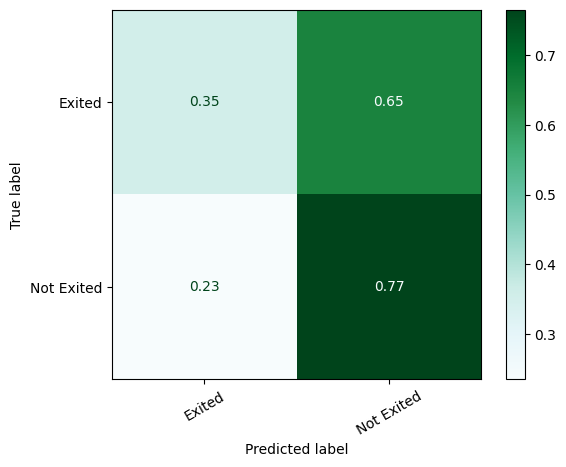

Sensitivity Of This Model Is :  0.351027397260274
Specificity Of This Model Is : :  0.7654109589041096


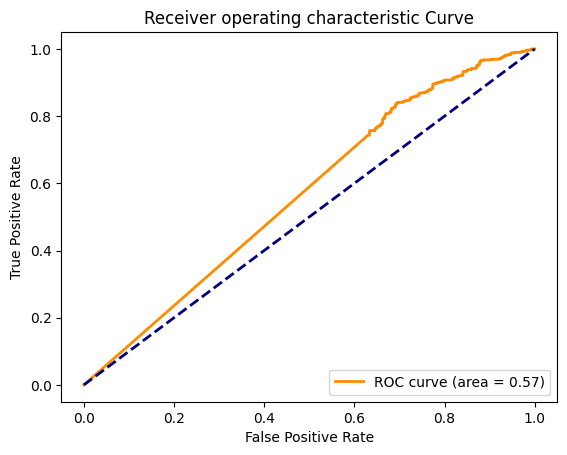

In [163]:
NeuralNetworks(TrainDataSetUnderSampling,Y_Train_DataUnderSampling,TestDataFinalUnderSampling,Y_Test_DataUnderSampling,80)
